In [1]:
# a demonstration of use of the logistic regression classifier 
# for content classification on doc2vec docs vectors
# where logit probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
# [3] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# W2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from w2v_wrapper import W2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
# TODO: change
# small ones (lt 1000):
# product_list = product_list = ["amq", "webserver", "datagrid", "cdk",
#                 "developertoolset", "softwarecollections", "mobileplatform"]

# all:
product_list = product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]
# big ones:
# product_list = product_list = ["eap", "webserver", "fuse", "brms", "bpmsuite", "devstudio",
#                 "rhel", "openshift"]
content_basepath = "/home/michal/Documents/Projects/ml/project-classifier-poc/project-classifier-poc/data/content/playground/auto/nostem"

In [3]:
# initialize w2v_wrapper providing as well metadata about the models state
base_w2v_wrapper = W2VWrapper(content_basepath=content_basepath,
                              vector_length=500, content_categories=product_list)

base_w2v_wrapper.init_vocab_model(drop_short_docs=10)

2017-05-01 22:10:58,191 : INFO : collecting all words and their counts
2017-05-01 22:10:58,192 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-01 22:10:58,352 : INFO : PROGRESS: at sentence #10000, processed 1462558 words, keeping 41870 word types
2017-05-01 22:10:58,533 : INFO : PROGRESS: at sentence #20000, processed 3020434 words, keeping 69836 word types
2017-05-01 22:10:58,709 : INFO : PROGRESS: at sentence #30000, processed 4504158 words, keeping 84891 word types
2017-05-01 22:10:58,829 : INFO : PROGRESS: at sentence #40000, processed 5491887 words, keeping 97103 word types
2017-05-01 22:10:58,891 : INFO : collected 104005 word types from a corpus of 5971745 raw words and 43478 sentences
2017-05-01 22:10:59,136 : INFO : min_count=5 retains 31971 unique words (drops 72034)
2017-05-01 22:10:59,137 : INFO : min_count leaves 5844561 word corpus (97% of original 5971745)
2017-05-01 22:10:59,201 : INFO : deleting the raw counts dictionary of 104005 it

In [4]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    y_expected = y_expected.reset_index(drop=True)
    y_actual = y_actual.reset_index(drop=True)

    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)[0]]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [ ]:
accuracies = []
cat_accuracies = pd.DataFrame(columns=product_list)
logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])

# get all content labeled from base
doc_content = base_w2v_wrapper.all_content
doc_labels = base_w2v_wrapper.all_content_target

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)


for train_doc_indices, test_doc_indices in strat_kfold.split(doc_content, doc_labels):

    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)

    train_docs = doc_content[train_doc_indices]
    test_docs = doc_content[test_doc_indices]

    train_target = doc_labels[train_doc_indices]
    test_target = doc_labels[test_doc_indices]

    logging.info("K-Fold models init and training")

    w2v_wrapper_fold = W2VWrapper(content_basepath=content_basepath,
                                  vector_length=500, content_categories=product_list)

    # init and train split w2v_wrapper on limited content
    w2v_wrapper_fold.init_vocab_model(given_content_series=train_docs, given_content_targets=train_target)
    w2v_wrapper_fold.train_categories_models()

    # predict
    logging.info("Prediction collection")
    y_actual = w2v_wrapper_fold.predict_all(test_docs)["y"]
    y_expected = test_target
    # compare expected and actual

    # evaluation:
    # logits
    logging.info("Probs collection")
    class_probs = w2v_wrapper_fold.score_documents_for_categories(docs=test_docs).values
    class_ordered = list(w2v_wrapper_fold.category_models.keys())

    class_actual_index = pd.Series(y_actual).apply(lambda cat_label: class_ordered.index(cat_label))
    actual_prob = class_probs[np.arange(len(class_actual_index)), class_actual_index]

    class_expected_index = pd.Series(y_expected).apply(lambda cat_label: class_ordered.index(cat_label))
    expected_prob = class_probs[np.arange(len(class_actual_index)), class_expected_index]

    new_logits = pd.DataFrame()
    new_logits["doc_id"] = test_doc_indices
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected.values
    logits = logits.append(new_logits)

    # accuracy
    logging.info("Split results:")
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.info("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               w2v_wrapper_fold.content_categories)
    logging.info("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=w2v_wrapper_fold.content_categories))

In [6]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-05-01 22:32:21,290 : INFO : split accuracies: [0.75948057917720069, 0.74916657087021499]
2017-05-01 22:32:21,301 : INFO : mean accuracy: 0.754323575024
2017-05-01 22:32:21,311 : INFO : categories accuracies: 
        amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.160305  0.869435   0.286458  0.285714  0.711312  0.319853  0.342222   
0  0.122137  0.857416   0.272251  0.317460  0.690493  0.316176  0.360000   

   devstudio       cdk  developertoolset      rhel  softwarecollections  \
0   0.671111  0.133333          0.000000  0.889486                  0.0   
0   0.654815  0.066667          0.666667  0.892473                  0.0   

   mobileplatform  openshift  
0        0.714286   0.735336  
0        0.650000   0.726753  
2017-05-01 22:32:21,314 : INFO : categories accuracies mean: 
amq                    0.141221
eap                    0.863425
webserver              0.279355
datagrid               0.301587
fuse                   0.700902
brms            

In [7]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,5
9,developertoolset,0.333333,12
8,cdk,0.100000,72
12,mobileplatform,0.682143,101
3,datagrid,0.301587,314
0,amq,0.141221,654
2,webserver,0.279355,956
6,bpmsuite,0.351111,1123
5,brms,0.318015,1358
7,devstudio,0.662963,3373


In [8]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
logits["doc_id"] = logits["doc_id"].apply(lambda x: int(x))
logits = logits.set_index("doc_id")
logits.head(25)

,actual_class,actual_prob,expected_class,expected_prob
doc_id,,,,
39056,rhel,0.074128,rhel,0.074128
1757,eap,0.595366,eap,0.595366
2911,eap,0.576739,eap,0.576739
30870,devstudio,0.081796,devstudio,0.081796
14298,eap,0.570222,eap,0.570222
36482,rhel,0.033459,rhel,0.033459
41677,openshift,0.228088,openshift,0.228088
40499,eap,0.513291,openshift,0.304944
32571,devstudio,0.096554,devstudio,0.096554


In [9]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = logits[logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['rhel', 'eap', 'devstudio', 'openshift', 'fuse', 'brms'], dtype=object)

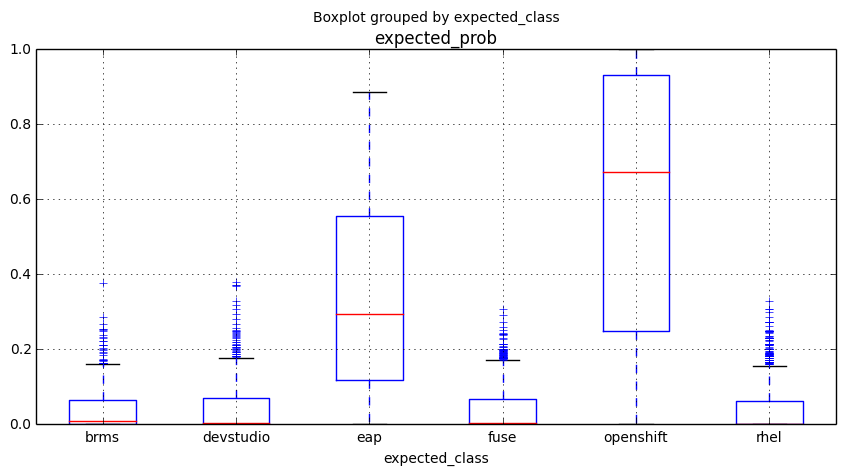

In [10]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,5))

In [11]:
# incorrect classification characteristics
wrong_docs_ids = pd.Series(logits[logits["expected_class"] != logits["actual_class"]].index)

wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: base_w2v_wrapper.get_doc_content(int(doc_id), word_split=True))
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))
wrong_docs_len.describe()

count     4275.000000
mean       129.724444
std       1257.369406
min         10.000000
25%         18.000000
50%         31.000000
75%         64.500000
max      79212.000000
Name: doc_id, dtype: float64

In [12]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(logits)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
# data need to be indexed incrementally for later plotting
correct_docs.index=np.arange(len(correct_docs))
correct_docs_wordlist = correct_docs.apply(lambda doc_id: base_w2v_wrapper.get_doc_content(doc_id, word_split=True))
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count    16247.000000
mean       159.218502
std        554.125300
min         10.000000
25%         28.000000
50%         58.000000
75%        135.000000
max      56006.000000
dtype: float64

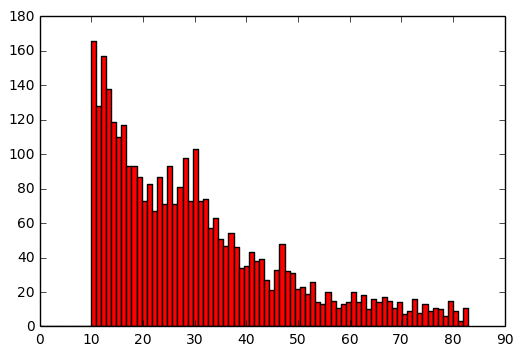

In [13]:
# missclassified docs length distribution
bordering_q = 0.8
bordering_q_value = int(wrong_docs_len.quantile(q=bordering_q))
plt.hist(wrong_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="r")
plt.show()

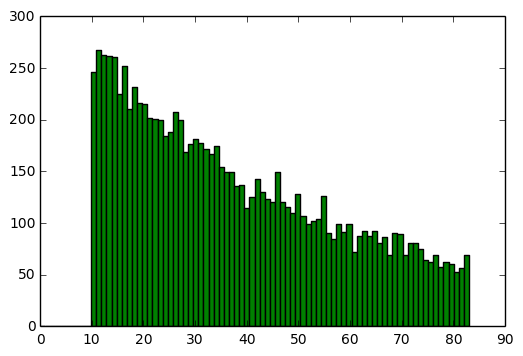

In [14]:
# correctly classified length distribution
plt.hist(correct_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="g")
plt.show()

<Container object of 83 artists>

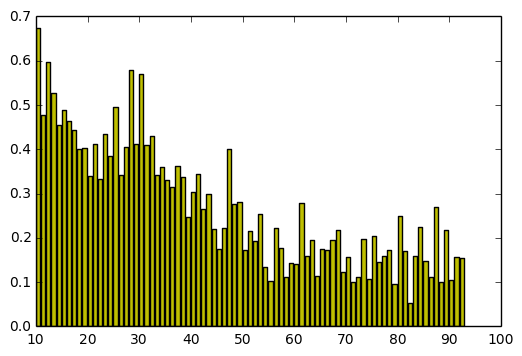

In [15]:
# distribution of incorrectly/correctly classified ratio by docs length
doc_len_error = (wrong_docs_len.value_counts() / correct_docs_len.value_counts())
ploted_doc_len_error = doc_len_error[:bordering_q_value]

plt.bar(ploted_doc_len_error.index, ploted_doc_len_error, color="y")

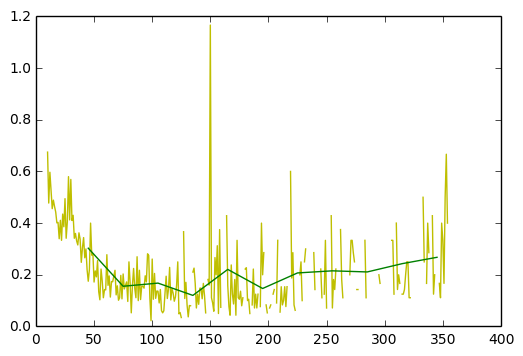

In [16]:
error_plot_border = 350
error_ploted = doc_len_error[:error_plot_border]
plt.plot(error_ploted.index, error_ploted, color="y")

mean_range = 30
mean_plot_ids = range(mean_range, error_plot_border+mean_range, mean_range)
mean_plot_vals = map(lambda mean_id: error_ploted.iloc[mean_id-5-mean_range: mean_id+5-mean_range].mean(), mean_plot_ids)
mean_plot = pd.Series(mean_plot_vals)
mean_plot.index = np.array(mean_plot_ids)-mean_range/2
plt.plot(mean_plot.index , mean_plot, color="g")

In [17]:
# above: rolling/moving average

In [18]:
# docs get associated with its content
logits["content_len"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                len(base_w2v_wrapper.get_doc_content(int(doc_id), word_split=True))).values
logits["content"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                base_w2v_wrapper.get_doc_content(int(doc_id), word_split=False)).values

In [19]:
# incorrectly classified docs with its content
logits[logits["actual_class"] != logits["expected_class"]][:30]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
40499,eap,0.513291,openshift,0.304944,122,trying protect administration domain com edit ...
20111,eap,0.574989,datagrid,0.044960,28,observed netstat takes seconds hotrod client d...
10764,openshift,0.192921,eap,0.339597,19,need add jboss tools eclipse springtoolsuite s...
40012,fuse,0.062750,openshift,0.121529,43,denver red hat customer convergence complete r...
30238,rhel,0.009149,devstudio,0.049687,21,installer vagrantfile provided cdk provided re...
40288,amq,0.059687,openshift,0.109160,97,red hat xpaas provides images red hat middlewa...
39999,rhel,0.069913,openshift,0.238839,36,http www blackmesh com cloud solutions latest ...
20330,amq,0.037403,fuse,0.045932,583,openshift enterprise red hat designed applicat...
27013,amq,0.046954,fuse,0.023565,43,enabling ldap authentication red hat jboss fus...


In [20]:
# misclassified docs with its content 
content_array = logits[logits["actual_class"] != logits["expected_class"]].iloc[:10]["content"].values
content_index = logits[logits["actual_class"] != logits["expected_class"]].iloc[:10].index.values
content_both = ["%s: %s" % (content_index[x], content_array[x]) for x in range(len(content_index))]
print reduce(lambda x, y: "%s\n\n%s" % (x, y), content_both)

40499: trying protect administration domain com edit realm jdbc development machine glassfish thing working openshift jboss myproject openshift config standalone xml myproject src main webapp web inf jboss web xml java jaas loginrealm myproject src main webapp web inf web xml administration constraint administration authorisation area edit post headchef form loginrealm viewlogin jsf viewerror jsf administrator headchef normal user create recipes cook example url http myproject namespace rhcloud com edit somepages access directly login page displayed access login page viewlogin jsf directly try login jboss tells javax servlet servletexception authenticator available programmatic login dont know wrong able access administration login exception generating password hashes hashing sha hashstring password com google common base charsets utf tostring possible set encoding password algorithm function appreciate help.

20111: observed netstat takes seconds hotrod client dead connections pool po

In [21]:
content_array = logits[logits["actual_class"] == "cdk"]["content"].values
content_index = logits[logits["actual_class"] == "cdk"].iloc[:10].index.values
content_both = ["%s: %s" % (content_index[x], content_array[x]) for x in range(len(content_index))]
print reduce(lambda x, y: "%s\n\n%s" % (x, y), content_both)

552: destination staticallyincludeddestinations excludeddestinations excludeddestinations behavior obeyed messages forwarded target amq instance networkconnectors.

30460: version names needs updating ensure proper update hibernate jbpm waiting hear koen.

39871: red hat enterprise linux red hat enterprise linux red hat enterprise linux team viewer.

40210: openshift later sonatype nexus running proxy defined npm packages binary raw repository nodejs application node sass dependency.

20638: fuse filesystem userspace interface userspace programs export virtual file linux kernel fuse aims provide secure method non privileged users create mount file implementations fuse implement fully functional file userspace program consists main parts kernel filesystem module userspace library mount utility package contains mount utility fusermount fuse userspace tool mount fuse file systems note fuse relationship spectrum emulator known fuse looking mount fuse file systems use fuse install new packa